**심장 질환의 개인 주요 지표를 데이터로 사용**

건강상태와 관련된 성인 40만 명을 대상으로 한 2020년 연간 CDC 조사 데이터

In [ ]:
# 파일 불러오기
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install category_encoders
!pip install imblearn
!pip install eli5
!pip install pdpbox
!pip install shap

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import eli5
import warnings

from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
from category_encoders import OneHotEncoder, OrdinalEncoder, TargetEncoder
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import validation_curve , RandomizedSearchCV, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from scipy.stats import randint, uniform
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, classification_report
from xgboost import XGBClassifier
from eli5.sklearn import PermutationImportance
from pdpbox.pdp import pdp_isolate, pdp_plot, PDPIsolate, pdp_interact, pdp_interact_plot

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
filename = '/content/drive/MyDrive/heart_2020_cleaned.csv'

In [ ]:
df = pd.read_csv(filename)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      319795 non-null  object 
 1   BMI               319795 non-null  float64
 2   Smoking           319795 non-null  object 
 3   AlcoholDrinking   319795 non-null  object 
 4   Stroke            319795 non-null  object 
 5   PhysicalHealth    319795 non-null  float64
 6   MentalHealth      319795 non-null  float64
 7   DiffWalking       319795 non-null  object 
 8   Sex               319795 non-null  object 
 9   AgeCategory       319795 non-null  object 
 10  Race              319795 non-null  object 
 11  Diabetic          319795 non-null  object 
 12  PhysicalActivity  319795 non-null  object 
 13  GenHealth         319795 non-null  object 
 14  SleepTime         319795 non-null  float64
 15  Asthma            319795 non-null  object 
 16  KidneyDisease     31

# **컬럼 정보**



*   HeartDisease
관상동맥심장질환(CHD) 또는 심근경색(MI)이 있다고 보고된 적이 있는 응답자
*   BMI
체질량 지수(BMI)


*   Smoking	
평생 최소 100개비 이상 피우셨나요? [주의: 5갑 = 100개비]

*   AlcoholDrinking
과음자(성인 남성은 주당 14잔 이상, 성인 여성은 주당 7잔 이상)

*   Stroke	
(말한 적 있음) (당신은) 뇌졸중이 있습니까?

*   PhysicalHealth
지금 귀하의 신체적 질병과 부상을 포함한 신체적 건강을 생각해보면, 지난 30일 동안 귀하의 신체 건강이 좋지 않았던 날은 며칠입니까? (0-30일)
*   MentalHealth
귀하의 정신건강을 생각해보면, 지난 30일 동안 귀하의 정신건강이 좋지 않은 날은 며칠입니까? (0-30일)


*   DiffWalking
걷거나 계단을 오르는데 심각한 어려움이 있습니까?	


*   Sex
당신은 남성 또는 여성이다?	


*   AgeCategory
( 14레벨 )연령 범주	



*   Race
전가된 인종/민족 가치	
*   Diabetic
당뇨병이 있습니까?


*   PhysicalActivity
지난 30일 동안 일상 업무 이외의 신체 활동이나 운동을 했다고 신고한 성인

*   GenHealth
일반적으로 당신의 건강은 어떠한가?

*   SleepTime
귀하는 24시간 중 평균 몇 시간의 수면을 취하십니까?	
*   Asthma
천식이 있습니까?


*   KidneyDisease
신장 결석, 방광 감염 또는 요실금을 제외하고 신장 질환이 있습니까?


*   SkinCancer
피부암이 있습니까?

In [ ]:
# 타겟의 비율 _ 분류
df['HeartDisease'].value_counts(normalize=True)

No     0.914405
Yes    0.085595
Name: HeartDisease, dtype: float64

In [ ]:
df.describe()

,BMI,PhysicalHealth,MentalHealth,SleepTime
count,319795.000000,319795.00000,319795.000000,319795.000000
mean,28.325399,3.37171,3.898366,7.097075
std,6.356100,7.95085,7.955235,1.436007
min,12.020000,0.00000,0.000000,1.000000
25%,24.030000,0.00000,0.000000,6.000000
50%,27.340000,0.00000,0.000000,7.000000
75%,31.420000,2.00000,3.000000,8.000000
max,94.850000,30.00000,30.000000,24.000000


In [ ]:
# unique 확인
df.describe(exclude='number').T.sort_values(by='unique')

,count,unique,top,freq
HeartDisease,319795,2,No,292422
Smoking,319795,2,No,187887
AlcoholDrinking,319795,2,No,298018
Stroke,319795,2,No,307726
DiffWalking,319795,2,No,275385
Sex,319795,2,Female,167805
PhysicalActivity,319795,2,Yes,247957
Asthma,319795,2,No,276923
KidneyDisease,319795,2,No,308016
SkinCancer,319795,2,No,289976


In [ ]:
# 이진변환_ 성별은 그대로 처리
data = df.replace({'Yes': 1, 'No': 0,'Yes (during pregnancy)': 1,'No, borderline diabetes': 0})
data

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,0,16.60,1,0,0,3.0,30.0,0,Female,55-59,White,1,1,Very good,5.0,1,0,1
1,0,20.34,0,0,1,0.0,0.0,0,Female,80 or older,White,0,1,Very good,7.0,0,0,0
2,0,26.58,1,0,0,20.0,30.0,0,Male,65-69,White,1,1,Fair,8.0,1,0,0
3,0,24.21,0,0,0,0.0,0.0,0,Female,75-79,White,0,0,Good,6.0,0,0,1
4,0,23.71,0,0,0,28.0,0.0,1,Female,40-44,White,0,1,Very good,8.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319790,1,27.41,1,0,0,7.0,0.0,1,Male,60-64,Hispanic,1,0,Fair,6.0,1,0,0
319791,0,29.84,1,0,0,0.0,0.0,0,Male,35-39,Hispanic,0,1,Very good,5.0,1,0,0
319792,0,24.24,0,0,0,0.0,0.0,0,Female,45-49,Hispanic,0,1,Good,6.0,0,0,0
319793,0,32.81,0,0,0,0.0,0.0,0,Female,25-29,Hispanic,0,0,Good,12.0,0,0,0


In [ ]:
data.describe(exclude='number').T.sort_values(by='unique')

,count,unique,top,freq
Sex,319795,2,Female,167805
GenHealth,319795,5,Very good,113858
Race,319795,6,White,245212
AgeCategory,319795,13,65-69,34151


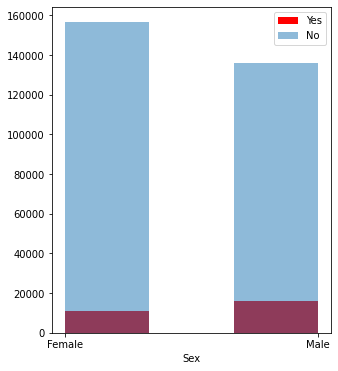

In [ ]:
# 데이터 그래프_1
# 성별 데이터 자르기
data_sex = data[['HeartDisease','Sex']]
# 그래프 크기
fig, ax = plt.subplots(figsize = (5,6))
# 막대 그래프
ax.hist(data_sex[data_sex['HeartDisease']==1]['Sex'], bins=3, color='red',label='Yes')
ax.hist(data_sex[data_sex['HeartDisease']==0]['Sex'], bins=3, alpha=0.5, label='No')
# 라벨 설정
ax.set_xlabel('Sex', fontsize = 10)
ax.legend();

표본수는 남성이 적지만, 심장질환을 앓고 있다고 답한 사람의 수가 여성보다 남성이 더 많은 것을 알수 있다.

In [ ]:
# GenHealth_비율
data_Gen = data[['HeartDisease','GenHealth']]
# 각 비율
data_Gen_Fair = data_Gen[data_Gen['GenHealth']== 'Fair']
print(data_Gen_Fair.value_counts(normalize=True).round(2))
data_Gen_Poor = data_Gen[data_Gen['GenHealth']== 'Poor']
print(data_Gen_Poor.value_counts(normalize=True).round(2))
data_Gen_Good = data_Gen[data_Gen['GenHealth']== 'Good']
print(data_Gen_Good.value_counts(normalize=True).round(2))
data_Gen_Verygood = data_Gen[data_Gen['GenHealth']== 'Very good']
print(data_Gen_Verygood.value_counts(normalize=True).round(2))
data_Gen_Excellent = data_Gen[data_Gen['GenHealth']== 'Excellent']
print(data_Gen_Excellent.value_counts(normalize=True).round(2))

HeartDisease  GenHealth
0             Fair         0.8
1             Fair         0.2
dtype: float64
HeartDisease  GenHealth
0             Poor         0.66
1             Poor         0.34
dtype: float64
HeartDisease  GenHealth
0             Good         0.9
1             Good         0.1
dtype: float64
HeartDisease  GenHealth
0             Very good    0.95
1             Very good    0.05
dtype: float64
HeartDisease  GenHealth
0             Excellent    0.98
1             Excellent    0.02
dtype: float64


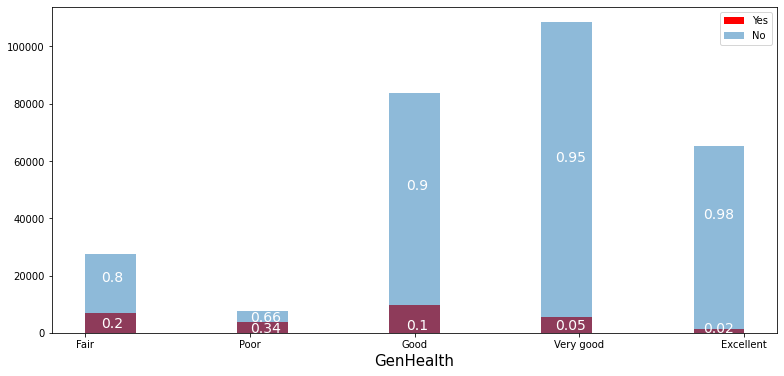

In [ ]:
# 데이터 그래프_2
# 자가 건강상태 데이터 자르기
data_Gen = data[['HeartDisease','GenHealth']]
# 그래프 크기
fig, ax = plt.subplots(figsize = (13,6))
# 막대 그래프
ax.hist(data_Gen[data_Gen['HeartDisease']==1]['GenHealth'], bins=13, color='red',label='Yes')
ax.hist(data_Gen[data_Gen['HeartDisease']==0]['GenHealth'], bins=13, alpha=0.5, label='No')
# 텍스트 설정
font = {'color':  'White', 'size': 14}
# Fair
plt.text(0.1, 18000.0, '0.8', fontdict=font)
plt.text(0.1, 2000, '0.2', fontdict=font)
# Poor
plt.text(1.0, 4000.0, '0.66', fontdict=font)
plt.text(1.0, 1.0, '0.34', fontdict=font)
# Good
plt.text(1.95, 50000.0, '0.9', fontdict=font)
plt.text(1.95, 1000.0, '0.1', fontdict=font)
# Very good
plt.text(2.85, 60000.0, '0.95', fontdict=font)
plt.text(2.85, 1000.0, '0.05', fontdict=font)
# Excellent
plt.text(3.75, 40000.0, '0.98', fontdict=font)
plt.text(3.75, 1.0, '0.02', fontdict=font)
# 라벨 설정
ax.set_xlabel('GenHealth', fontsize = 15)
ax.legend();

평소 느끼는 건강의 상태를 그래프로 확인한 결과

의외로 'Good'이라고 답한 사람 중 심장질환을 앓고 있는 경우가 많고 생각 했으나, 

비율로 확인해본 결과
건강 상태를 안좋게 느낄수록 심장질환의 여부가 점차 늘어나는 것을 알 수 있다. 

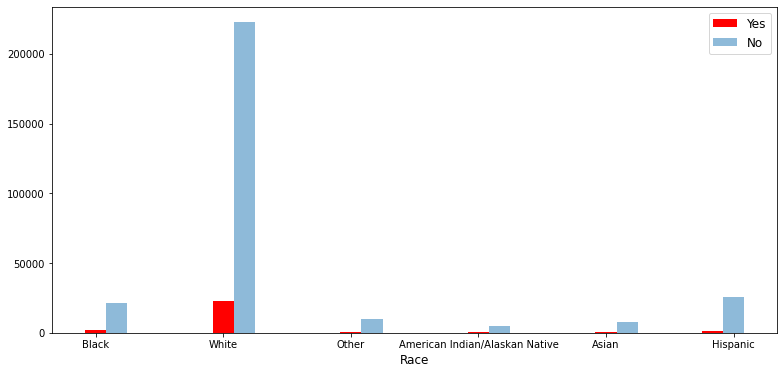

In [ ]:
# 데이터 그래프_3
# 인종 데이터 자르기
data_Race = data[['HeartDisease','Race']]
# 그래프 크기
fig, ax = plt.subplots(figsize = (13,6))
# 막대 그래프
ax.hist(data_Race[data_Race['HeartDisease']==1]['Race'], bins=30, color='red',label='Yes',align='left')
ax.hist(data_Race[data_Race['HeartDisease']==0]['Race'], bins=30, alpha=0.5, label='No',align='right')
# 라벨 설정
ax.set_xlabel('Race', fontsize=12)          

ax.legend(['Yes', 'No'], fontsize=12) 

In [ ]:
# Race_비율
data_Race = data[['HeartDisease','Race']]
# 각 비율
data_Race_Black = data_Race[data_Race['Race']== 'Black']
print(data_Race_Black.value_counts(normalize=True).round(2))
data_Race_White = data_Race[data_Race['Race']== 'White']
print(data_Race_White.value_counts(normalize=True).round(2))
data_Race_Asian = data_Race[data_Race['Race']== 'Asian']
print(data_Race_Asian.value_counts(normalize=True).round(2))
data_Race_American = data_Race[data_Race['Race']== 'American Indian/Alaskan Native']
print(data_Race_American.value_counts(normalize=True).round(2))
data_Race_Other = data_Race[data_Race['Race']== 'Other']
print(data_Race_Other.value_counts(normalize=True).round(2))
data_Race_Hispanic = data_Race[data_Race['Race']== 'Hispanic']
print(data_Race_Hispanic.value_counts(normalize=True).round(2))

HeartDisease  Race 
0             Black    0.92
1             Black    0.08
dtype: float64
HeartDisease  Race 
0             White    0.91
1             White    0.09
dtype: float64
HeartDisease  Race 
0             Asian    0.97
1             Asian    0.03
dtype: float64
HeartDisease  Race                          
0             American Indian/Alaskan Native    0.9
1             American Indian/Alaskan Native    0.1
dtype: float64
HeartDisease  Race 
0             Other    0.92
1             Other    0.08
dtype: float64
HeartDisease  Race    
0             Hispanic    0.95
1             Hispanic    0.05
dtype: float64


비율을 확인해본 결과 

백인이 심장질환을 앓고 있는 경우가 제일 많았다.

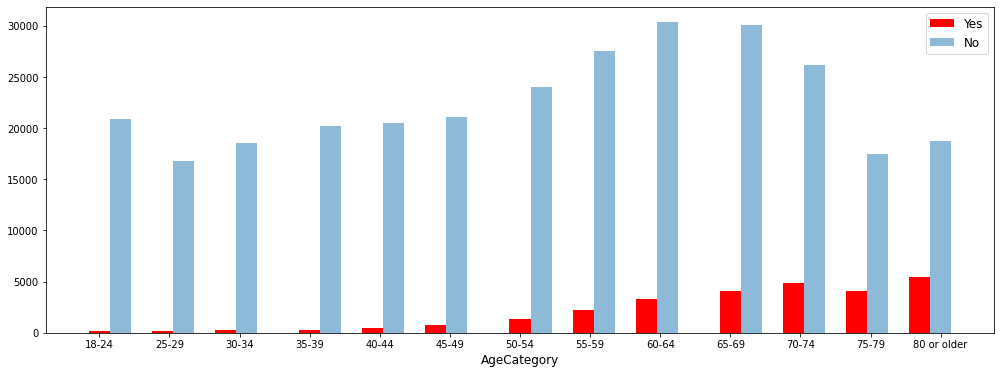

In [ ]:
# 데이터 그래프_4
# 나이 데이터 자르기
data_Age = data[['HeartDisease','AgeCategory']].sort_values(by='AgeCategory')
# 그래프 크기
fig, ax = plt.subplots(figsize = (17,6))
# 막대 그래프
ax.hist(data_Age[data_Age['HeartDisease']==1]['AgeCategory'], bins=40, color='red',label='Yes',align='left')
ax.hist(data_Age[data_Age['HeartDisease']==0]['AgeCategory'], bins=40, alpha=0.5, label='No',align='right')
# 라벨 설정
ax.set_xlabel('AgeCategory', fontsize=12)

ax.legend(['Yes', 'No'], fontsize=12) 

나이가 많아 질수록 심장질환의 걸릴 가능성이 커지는것을 알 수 있다. 
그 중 50-65 사이에서 급격하게 증가한 것을 확인할수 있다.

In [ ]:
# 모델링 데이터 처리_순서형 카테고리
# 성별
data = data.replace ({'Male':1,'Female':0})
data.head(5)
# AgeCartegory_encode
AgeCategory_encode = {'18-24':0,
                       '25-29':1,
                       '30-34':2,
                       '35-39':3,
                       '40-44':4,
                       '45-49':5,
                       '50-54':6,
                       '55-59':7,
                       '60-64':8,
                       '65-69':9,
                       '70-74':10,
                       '75-79':11,
                       '80 or older':12}
data['AgeCategory_encode'] = data.AgeCategory.map(AgeCategory_encode)
data = data.drop('AgeCategory', axis=1)

# GenHealth_encode
GenHealth_encode = {'Fair' : 0,
                    'Poor' : 1,
                    'Good' : 2,
                    'Very good' : 3,
                    'Excellent' : 4
}
data['GenHealth_encode'] = data.GenHealth.map(GenHealth_encode)
data = data.drop('GenHealth', axis=1)


In [ ]:
# # 모델링 데이터 처리_onehotencorder
# Race_encode

OHE = OneHotEncoder(sparse=False)
OHE.fit(data[['Race']])

# 데이터프레임 만들기
df_OHE_R = pd.DataFrame(OHE.transform(data[['Race']]), columns=['American Indian/Alaskan Native',
                                                                'Asian',
                                                                'Black',
                                                                'Hispanic',
                                                                'Other',
                                                                'White'])
# 'Race' 삭제
data = data.drop('Race', axis=1)
# 데이터 합치기
data =  pd.concat([data,df_OHE_R] , axis=1)

data

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,Diabetic,...,KidneyDisease,SkinCancer,AgeCategory_encode,GenHealth_encode,American Indian/Alaskan Native,Asian,Black,Hispanic,Other,White
0,0,16.60,1,0,0,3.0,30.0,0,0,1,...,0,1,7,3,0.0,0.0,0.0,0.0,0.0,1.0
1,0,20.34,0,0,1,0.0,0.0,0,0,0,...,0,0,12,3,0.0,0.0,0.0,0.0,0.0,1.0
2,0,26.58,1,0,0,20.0,30.0,0,1,1,...,0,0,9,0,0.0,0.0,0.0,0.0,0.0,1.0
3,0,24.21,0,0,0,0.0,0.0,0,0,0,...,0,1,11,2,0.0,0.0,0.0,0.0,0.0,1.0
4,0,23.71,0,0,0,28.0,0.0,1,0,0,...,0,0,4,3,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319790,1,27.41,1,0,0,7.0,0.0,1,1,1,...,0,0,8,0,0.0,0.0,0.0,1.0,0.0,0.0
319791,0,29.84,1,0,0,0.0,0.0,0,1,0,...,0,0,3,3,0.0,0.0,0.0,1.0,0.0,0.0
319792,0,24.24,0,0,0,0.0,0.0,0,0,0,...,0,0,5,2,0.0,0.0,0.0,1.0,0.0,0.0
319793,0,32.81,0,0,0,0.0,0.0,0,0,0,...,0,0,1,2,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
# 데이터 세트 분리
from sklearn.model_selection import train_test_split

features = data.drop(columns =['HeartDisease'], axis = 1)
target = data['HeartDisease']
# 데이터 나누기_ 훈련 - 테스트 (train , test)
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, train_size=0.8, random_state=2)

print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (255836, 22)
X_test shape:  (63959, 22)
y_train shape:  (255836,)
y_test shape:  (63959,)


**데이터불균형 해결**

In [ ]:
SM = SMOTE(random_state = 0)
X_train ,y_train = SM.fit_resample(X_train,y_train)
print(X_train.shape,y_train.shape)

(467784, 22) (467784,)


In [ ]:
print('After OverSampling, the shape of train_X: {}'.format(X_train.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(X_train.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train==0)))

After OverSampling, the shape of train_X: (467784, 22)
After OverSampling, the shape of train_y: (467784, 22) 

After OverSampling, counts of label '1': 233892
After OverSampling, counts of label '0': 233892


In [ ]:
# 타겟의 비율 _ 분류
y_train.value_counts(normalize=True)

0    0.5
1    0.5
Name: HeartDisease, dtype: float64

**검증 곡선**

In [ ]:
pipe = make_pipeline(
    # TargetEncoder: 범주형 변수 인코더로, 타겟값을 특성의 범주별로 평균내어 그 값으로 인코딩
    TargetEncoder(min_samples_leaf=1, smoothing=1), 
    SimpleImputer(strategy='median'), 
    RandomForestRegressor(max_depth = 10, n_jobs=-1, random_state=2)
)

k = 3

scores = cross_val_score(pipe, X_train, y_train, cv=k, 
                         scoring='neg_mean_absolute_error')

print(f'MAE for {k} folds:', -scores)

MAE for 3 folds: [0.37019821 0.27571981 0.44073606]


In [ ]:
-scores.mean()

0.36221802604587955

In [ ]:
scores.std()

0.06760351822689104

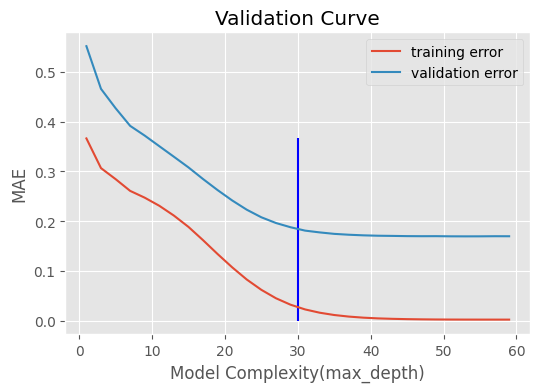

In [ ]:
pipe = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(), 
    DecisionTreeRegressor()
)

depth = range(1, 60, 2)
ts, vs = validation_curve(
    pipe, X_train, y_train
    , param_name='decisiontreeregressor__max_depth'
    , param_range=depth, scoring='neg_mean_absolute_error'
    , cv=3
    , n_jobs=-1
)

train_scores_mean = np.mean(-ts, axis=1)
validation_scores_mean = np.mean(-vs, axis=1)

fig, ax = plt.subplots()

# 훈련세트 검증곡선
ax.plot(depth, train_scores_mean, label='training error')

# 검증세트 검증곡선
ax.plot(depth, validation_scores_mean, label='validation error')

# 이상적인 max_depth
ax.vlines(30,0, train_scores_mean.max(), color='blue')

# 그래프 셋팅
ax.set(title='Validation Curve'
      , xlabel='Model Complexity(max_depth)', ylabel='MAE')
ax.legend()
fig.dpi = 100

**모델 비교**

In [ ]:
def fit(X_train, y_train):
    pipeline = None 
    clf = None  

    pipeline = make_pipeline(
        TargetEncoder(), 
        SimpleImputer(), 
        RandomForestClassifier(random_state=42, warm_start=True)
        )


    dists = {
    'targetencoder__smoothing': [2.,20.,50.,60.,100.,500.,1000.], # int로 넣으면 error(bug)
    'targetencoder__min_samples_leaf': randint(1, 10),     
    'simpleimputer__strategy': ['mean', 'median'], 
    'randomforestclassifier__n_estimators': randint(50, 500), 
    'randomforestclassifier__max_depth': [5, 10, 15, 20, None], 
    'randomforestclassifier__max_features': uniform(0, 1) # max_features
    }

    clf = RandomizedSearchCV(
        pipeline,
        param_distributions=dists,  
        n_iter=5, 
        cv=2, 
        scoring='neg_mean_absolute_error',  
        verbose=1,
        n_jobs=-1,
        refit=True
    )

    clf.fit(X_train, y_train)
    print("Optimal Hyperparameter:", clf.best_params_)
    print("AUC:", clf.best_score_)

    return clf


def predict(X, y, best_estimator):
    y_pred_proba = None
    #확률 반환
    clf = fit(X, y)

    # y_pred_proba = best_estimator.predict(X)
    y_pred_proba = best_estimator.predict_proba(X)[:, -1]

    report = classification_report(y, y_pred_proba > 0.5)
    return y_pred_proba, report

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
clf = fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/category_encoders/target_encoder.py:94: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/category_encoders/target_encoder.py:99: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/category_encoders/target_encoder.py:94: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/category_encoders/target_encoder.py:99: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  category=FutureWar

Fitting 2 folds for each of 5 candidates, totalling 10 fits


/usr/local/lib/python3.7/dist-packages/category_encoders/target_encoder.py:94: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/category_encoders/target_encoder.py:99: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  category=FutureWarning)


Optimal Hyperparameter: {'randomforestclassifier__max_depth': None, 'randomforestclassifier__max_features': 0.5938630727852457, 'randomforestclassifier__n_estimators': 363, 'simpleimputer__strategy': 'mean', 'targetencoder__min_samples_leaf': 9, 'targetencoder__smoothing': 2.0}
AUC: -0.1036247498845621


Fitting 2 folds for each of 5 candidates, totalling 10 fits
Optimal Hyperparameter: {'randomforestclassifier__max_depth': 15, 'randomforestclassifier__max_features': 0.08706441235000806, 'randomforestclassifier__n_estimators': 69, 'simpleimputer__strategy': 'mean', 'targetencoder__min_samples_leaf': 8, 'targetencoder__smoothing': 1000.0}
AUC: -0.08466361435871153
              precision    recall  f1-score   support

           0       0.93      0.92      0.93     58530
           1       0.24      0.27      0.25      5429

    accuracy                           0.86     63959
   macro avg       0.59      0.60      0.59     63959
weighted avg       0.87      0.86      0.87     63959



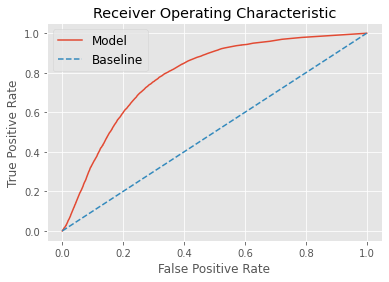

In [ ]:
def plot_roc(y, y_pred_proba):
    auc_score = roc_auc_score(y, y_pred_proba)
    fpr, tpr, _ = roc_curve(y, y_pred_proba)
    baseline_fpr, baseline_tpr, _ = roc_curve(y, [0] * len(y))

    plt.style.use("ggplot")
    plt.plot(fpr, tpr, label="Model")
    plt.plot(baseline_fpr, baseline_tpr, linestyle="--", label="Baseline")
    plt.xlabel("False Positive Rate", size=12)
    plt.ylabel("True Positive Rate", size=12)
    plt.title("Receiver Operating Characteristic")
    plt.legend(prop={"size": 12})
    plt.show()
    return auc_score


y_test_pred_proba, report = predict(X_test, y_test, clf.best_estimator_)
print(report)
auc_score = plot_roc(y_test, y_test_pred_proba)

In [ ]:
auc_score

Test AUC: 0.7848870042762233


In [ ]:
pipe2 = Pipeline([
    ('preprocessing', make_pipeline(OrdinalEncoder(), SimpleImputer())),
    ('rf', XGBClassifier(n_estimators=100
                  , random_state=42
                  , n_jobs=-1
                  , max_depth=7
                  , learning_rate=0.2)) 
])

pipe2.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('ordinalencoder',
                                  OrdinalEncoder(cols=[], mapping=[])),
                                 ('simpleimputer', SimpleImputer())])),
                ('rf',
                 XGBClassifier(learning_rate=0.2, max_depth=7, n_jobs=-1,
                               random_state=42))])

In [ ]:
print('검증 정확도: ', pipe2.score(X_test, y_test))

y_pred = pipe2.predict(X_test)
print(classification_report(y_test, y_pred))

검증 정확도:  0.8387560781125408
              precision    recall  f1-score   support

           0       0.94      0.88      0.91     58530
           1       0.25      0.44      0.32      5429

    accuracy                           0.84     63959
   macro avg       0.60      0.66      0.61     63959
weighted avg       0.88      0.84      0.86     63959



In [ ]:
# roc_curve(타겟값, prob of 1)
y_pred_proba = pipe2.predict_proba(X_test)[:, 1]
print('F1-score: ', f1_score(y_test, y_pred))

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc = pd.DataFrame({
    'FPR(Fall-out)': fpr, 
    'TPRate(Recall)': tpr, 
    'Threshold': thresholds
})
roc

F1-score:  0.315523992832017


,FPR(Fall-out),TPRate(Recall),Threshold
0,0.000000,0.000000,1.951052
1,0.000017,0.000000,0.951052
2,0.000017,0.000184,0.933353
3,0.000034,0.000184,0.929104
4,0.000034,0.000368,0.927422
...,...,...,...
13244,0.996942,0.999816,0.002413
13245,0.996942,1.000000,0.002413
13246,0.998291,1.000000,0.002043
13247,0.998326,1.000000,0.002035


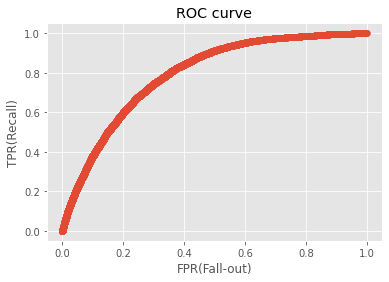

In [ ]:
plt.scatter(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)');

In [ ]:
auc_score = roc_auc_score(y_test, y_pred_proba)
auc_score

0.7924804971132715

**PDP**

In [ ]:
preprocess_pipeline = None
model = None

pipeline = Pipeline([('preprocess_pipeline', make_pipeline(TargetEncoder(),SimpleImputer())),
                     ('model', RandomForestClassifier())])
pipeline.fit(X_train,y_train)
preprocess_pipeline = pipeline.named_steps['preprocess_pipeline']
model = pipeline.named_steps['model']

X_test_preprocessed = None

X_test_preprocessed = pipeline.named_steps['preprocess_pipeline'].transform(X_test)

In [ ]:
def get_permutation_importance(X, y, model):
    permuter = None
    permuter = PermutationImportance(
        pipeline.named_steps['model'], 
        scoring='roc_auc', 
        n_iter=5, 
        random_state=42)

    permuter.fit(X, y)

    return permuter

In [ ]:
permuter = get_permutation_importance(X_test_preprocessed, y_test, model)
eli5.show_weights(permuter, top=None, feature_names=X_test.columns.tolist())
print("Top3 Important Features:")
p_i = sorted(
    list(zip(X_test.columns.tolist(), permuter.feature_importances_)),
    key=lambda x: x[1],
    reverse=True,
)
print(p_i[:3])

Top3 Important Features:
[('AgeCategory_encode', 0.0970454510908679), ('GenHealth_encode', 0.06478943327461913), ('White', 0.03114973352320034)]


In [ ]:
def get_pdp_isolated(dataset, model, feature):
    pdp_isolated = None

    pdp_isolated = pdp_isolate(
    model=model, 
    dataset=dataset, 
    model_features=dataset.columns, 
    feature=feature
    )

    return pdp_isolated

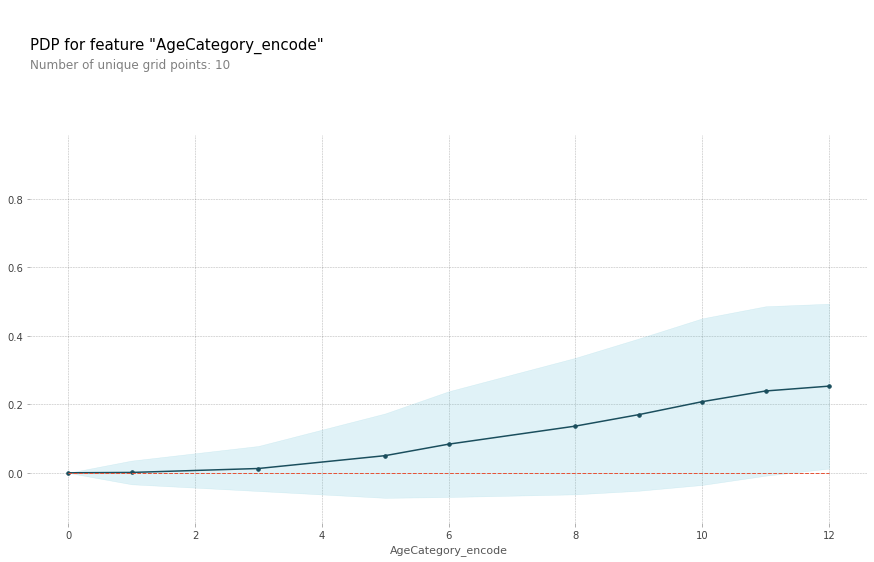

In [ ]:
X_test_preprocessed_df = pd.DataFrame(X_test_preprocessed, columns=X_test.columns)
feature = sorted(p_i, key=lambda x: x[1], reverse=True)[0][0]
pdp_isolated = get_pdp_isolated(X_test_preprocessed_df, model, feature)
pdp_plot(pdp_isolated, feature_name=feature)

assert isinstance(pdp_isolated, PDPIsolate)

In [ ]:
def get_pdp_interaction(dataset, model, features):
    pdp_interaction = None

    pdp_interaction = pdp_interact(
    model=model, 
    dataset=dataset,
    model_features=dataset.columns, 
    features=features
    )

    return pdp_interaction

(<Figure size 540x684 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f50a365e8d0>,
  'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f50a361cd50>})

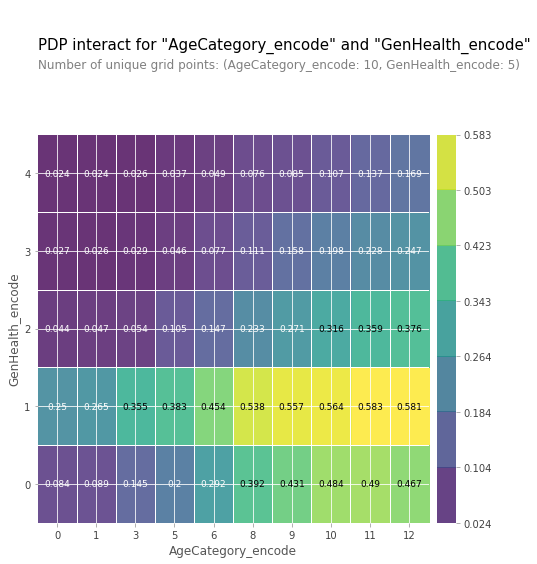

In [ ]:
features = list(map(lambda x: x[0], sorted(p_i, key=lambda x: x[1], reverse=True)))[:2]
pdp_interaction = get_pdp_interaction(
    X_test_preprocessed_df, model, features
)
pdp_interact_plot(pdp_interaction, feature_names=features, plot_type="grid")

결론 : 심장질환에 가장 영향을 많이 주는 지표는 나이와 평소 운동여부

나이는 많을 수록, 평소 운동을 지속하지 않는 경우에 심장 질환에 걸릴 확룰이 높다